- Plantear baseline / mvp
- Ventas -> + vendidos || + ingresos generan
- Rango de precios (premium, normal, etc...)
- Influencia de eventos en las ventas de los productos  
  
- Mantener las dimensiones por debajo de 4 a ser posible

# INIT

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [7]:
# !pip install featuretools # install the missing module # No lo vamos a usar esta vez

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

# Creacion caracteristicas
# import featuretools as ft

# Preprocesamiento
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler # Para evitar valores negativos

# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
# from modules import feature_creation_module as fcm
from modules import time_series_analisis as tma

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [9]:
CLUSTER_COL = 'cluster'
FIGSIZE = (12, 8)
FIG_SQUARE = (10,10)

## Importacion datos

### CSVs

In [10]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [11]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [12]:
# Seleccionamos de una semana antes a una despues de fin de año
# Convertir la columna 'date' a datetime si no lo está
df_s['date'] = pd.to_datetime(df_s['date'])

# Definir el rango de fechas desde 7 días antes del 1 de enero de 2014 hasta 7 días después del 1 de enero de 2016
start_date = '2013-12-25'  # 7 días antes del 1 de enero de 2014
end_date = '2016-01-07'    # 7 días después del 1 de enero de 2016

# Filtrar el DataFrame dentro del rango de fechas
df_s = df_s[(df_s['date'] >= start_date) & (df_s['date'] <= end_date)]

# df_s_origin = df_s.copy() # Para recuperar eventos

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

In [13]:
df_s.shape

(8356979, 12)

In [14]:
df_s.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8801219,SUPERMARKET_3_586,NYC_2,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None
8801220,SUPERMARKET_3_756,NYC_2,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801221,SUPERMARKET_3_565,NYC_3,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801222,SUPERMARKET_3_756,NYC_3,2013-12-25,2,2013,52,2.976,5.952,12,Wednesday,2,None
8801223,SUPERMARKET_3_555,BOS_1,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None


# SEGMENTACION

## Functions

In [16]:
# Librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# CONSTANTES
FIGSIZE = (12, 6)
CLUSTER_COL = 'cluster'
EVENTS = ['NewYear', 'SuperBowl', 'Ramadan starts', 'Easter', 'Thanksgiving']
SCALER = RobustScaler
# Podemos verlo por eventos independientes => EVENTS = ['Thanksgiving']

In [18]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

def features_creation(df):
  # Crea caracteristicas por STORE_CODE => FeatureTools
  # product_data = df.groupby('item').agg({
  #     'total_sales': 'sum',
  #     'units': 'sum',
  #     'avg_product_sales': 'mean',
  #     'sell_price': 'mean'
  # }).reset_index()
  product_data = df.groupby('store_code').agg({
      'total_sales': 'sum',
      'units': 'sum',
      'avg_product_sales': 'mean',
      'sell_price': 'mean'
  }).reset_index()

  # Selecciona solo las caracteristicas creadas => FeatureTools
  features = ['total_sales', 'units', 'avg_product_sales', 'sell_price']
  df_features = product_data[features]
  return df_features, features, product_data


In [19]:
# 1. Preparación de datos
def prepare_data(df):
    df['date'] = pd.to_datetime(df['date'])
    # Renombramos raw_earn a total_sales
    df.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return df

# 2. Crear features
def create_date_features(df):
    events = EVENTS
    generated_columns = []

    # Crear un DataFrame con todas las fechas de eventos
    event_dates = df[df['event'].isin(events)].groupby('event')['date'].min()

    # Calcular los días hasta cada evento de manera vectorizada
    for event in events:
        col_name = f'days_to_{event}'
        # col_name = f'avg_days_to_{event}'
        df[col_name] = (df['date'] - event_dates[event]).dt.days
        # df[col_name] = (df['date'] - event_dates[event]).dt.days
        generated_columns.append(col_name)

    # Calcular promedios de manera vectorizada => Para analisis posterior
    df['avg_product_sales'] = df.groupby('item')['total_sales'].transform('mean')
    df['avg_store_sales'] = df.groupby('store_code')['total_sales'].transform('mean')

    return df

# 3. Segmentación de tiendas usando K-means con RobustScaler
# 3.1 - Grafico silueta
def plot_silhouette(data_scaled, ran=20):

  silhouette_scores = []

  for k in range(2, ran):
      kmeans = init_kmeans(k)
      kmeans.fit(data_scaled)
      silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

  fig = px.line(
      x=range(2, ran),
      y=silhouette_scores,
      title="Silhouette score",
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

# 3.2 - Segementacion con optimal_k
def segment_stores_kmeans(df, n_clusters=3):

    # FEATURE TOOLS -> helper
    X = data['df_features']
    features = data['features']
    store_data = data['store_data']
    X_scaled = data['X_scaled']
    scaler = data['scaler']
    # END FEATURE TOOLS

    # Aplica Kmeans sobre DF scalado -> helper
    kmeans = init_kmeans(n_clusters)
    store_data[CLUSTER_COL] = kmeans.fit_predict(X_scaled)

    # Calcula Silueta
    silhouette_avg = silhouette_score(X_scaled, store_data[CLUSTER_COL])
    print(f"El score de silueta promedio es: {silhouette_avg}")

    # Obtiene centroides y los devuelve en un DF
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=features)
    centroid_df[CLUSTER_COL] = range(n_clusters)
    print("\nCentroides de los clusters:")
    print(centroid_df)

    return store_data, centroid_df

# 4. Análisis de eventos integrado con segmentación
def analyze_events_with_segments(df, store_segments):
    events = EVENTS

    # df = df.merge(store_segments[['item', CLUSTER_COL]], on='item', how='left')
    df = df.merge(store_segments[['store_code', CLUSTER_COL]], on='store_code', how='left')

    # Preparar los datos para todos los eventos de una vez
    event_data = df.melt(id_vars=[CLUSTER_COL, 'total_sales', 'units'],
                         value_vars=[f'days_to_{event}' for event in events],
                         var_name='event', value_name='days_to_event')
    event_data['event'] = event_data['event'].str.replace('days_to_', '')

    # Filtrar para el período del evento (-7 a 7 días)
    event_data = event_data[event_data['days_to_event'].between(-7, 7)]

    # Agrupar y agregar datos
    cluster_analysis = event_data.groupby(['event', CLUSTER_COL, 'days_to_event']).agg({
        'total_sales': 'sum',
        'units': 'sum'
    }).reset_index()

    # Convertir a diccionario para mantener la estructura de salida anterior
    event_analysis = {event: cluster_analysis[cluster_analysis['event'] == event] for event in events}

    return event_analysis

# 5. Visualización de resultados
def visualize_results(store_segments, event_analysis, centroid_df):
    # Visualización de clusters
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=store_segments, x='total_sales', y='sell_price', hue=CLUSTER_COL, palette='viridis')
    sns.scatterplot(data=centroid_df, x='total_sales', y='sell_price', s=200, color='red', marker='X')
    plt.title('Segmentación de tiendas')
    plt.xlabel('Ventas totales')
    plt.ylabel('Precio de venta promedio')
    plt.show()

    # Visualización de evento por cluster
    event_data = pd.concat(event_analysis.values())
    g = sns.FacetGrid(event_data, col="event", hue="cluster", col_wrap=3, height=4, aspect=1.5)
    g.map(plt.plot, "days_to_event", "total_sales")
    g.add_legend()
    g.fig.suptitle('Ventas por cluster durante eventos', y=1.02)
    for ax in g.axes:
        ax.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

# Análisis adicional: Impacto relativo de eventos por cluster
def analyze_event_impact(event_analysis):
    impact_analysis = []
    for event, data in event_analysis.items():
      # Ventas pre y post evento
        pre_event = data[data['days_to_event'] < 0].groupby(CLUSTER_COL)['total_sales'].mean()
        post_event = data[data['days_to_event'] >= 0].groupby(CLUSTER_COL)['total_sales'].mean()

      # Impacto porcentual -> Diferencia despues y antes (Ha sido positiva o negativa?)
        impact = ((post_event - pre_event) / pre_event * 100).reset_index()
        impact.columns = [CLUSTER_COL, 'percent_change']
        impact['event'] = event
        impact_analysis.append(impact)

    impact_df = pd.concat(impact_analysis, ignore_index=True)

    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(x='event', y='percent_change', hue=CLUSTER_COL, data=impact_df)
    plt.title('Impacto porcentual de eventos por cluster')
    plt.xlabel('Evento')
    plt.ylabel('Cambio porcentual en ventas')
    plt.xticks(rotation=45)

    # Añadir etiquetas de porcentaje encima de cada barra
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.1f}%',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom',
                         fontsize=10, color='black',
                         xytext=(0, 5),  # Desplazamiento en y
                         textcoords='offset points')

    plt.show()

    return impact_df

In [15]:
print('DONE')

DONE


## Load data

In [20]:
items = df_items.copy()
shops = df_shops.copy()
df_events = df_s.copy()

display(df_events.shape)

(8356979, 12)

In [21]:
df_events.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8801219,SUPERMARKET_3_586,NYC_2,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None
8801220,SUPERMARKET_3_756,NYC_2,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801221,SUPERMARKET_3_565,NYC_3,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801222,SUPERMARKET_3_756,NYC_3,2013-12-25,2,2013,52,2.976,5.952,12,Wednesday,2,None
8801223,SUPERMARKET_3_555,BOS_1,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None


## Tareas

In [22]:
# Preparamos df original
df = prepare_data(df_events) # total_sales = raw_earn

In [23]:
# Creacion caracteristicas sobre fecha (distancia a eventos de cada fecha / venta de item para analisis posterior)
df = create_date_features(df)

In [24]:
# Creacion caracteristicas para segmentacion
df_features, features, store_data = features_creation(df)

In [25]:
# Preprocesamiento
scaled_df, scaler = preprocess_features(df_features, Scaler=SCALER)

In [26]:
# Silhouette
plot_silhouette(scaled_df, ran=9)

In [27]:
# Segmentacion con optimal_k
optimal_k = 2 # Segun grafico de silueta

data = {
    'df_features': df_features,
    'features': features,
    'store_data': store_data,
    'X_scaled': scaled_df,
    'scaler': scaler
}

store_segments, centroid_df = segment_stores_kmeans(data, n_clusters=optimal_k)

El score de silueta promedio es: 0.5476787644117722

Centroides de los clusters:
    total_sales         units  avg_product_sales  sell_price  cluster
0  9.262689e+06  2.521020e+06          12.094335    4.789940        0
1  1.727466e+07  4.667321e+06          11.805568    4.991165        1


In [34]:
# Clusters asignados a items
store_segments.head()

,store_code,total_sales,units,avg_product_sales,sell_price,cluster
0,BOS_1,8.372667e+06,2292731,12.534097,4.780196,0
1,BOS_2,1.016845e+07,2745173,12.277105,4.859419,0
2,BOS_3,1.009387e+07,2620406,12.523005,4.879028,0
3,NYC_1,1.217453e+07,3238077,11.840998,4.972541,0
4,NYC_2,8.871384e+06,2262857,12.092067,4.994075,0


In [32]:
event_analysis = analyze_events_with_segments(df, store_segments)

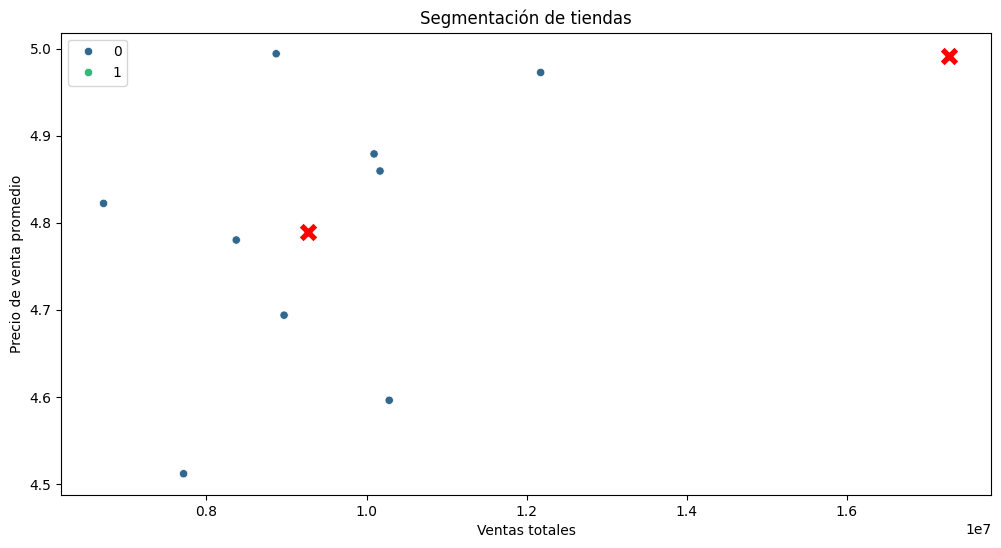

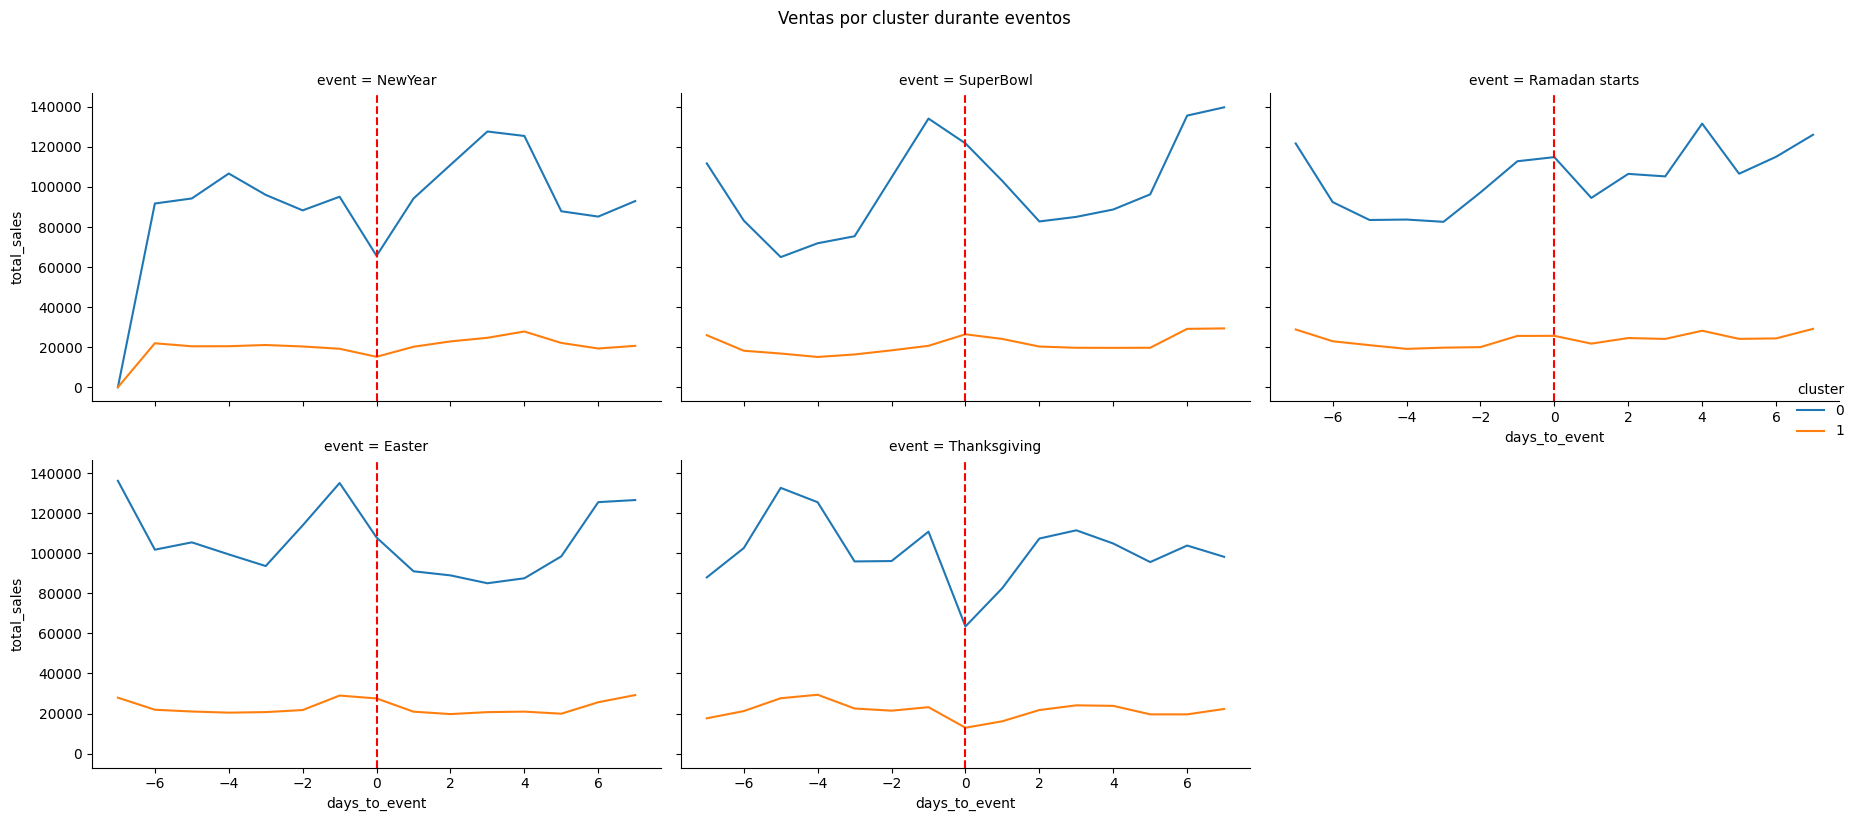

In [33]:
visualize_results(store_segments, event_analysis, centroid_df)

In [35]:
# Seleccionamos de store_sements solo los registros store_code = 'NYC_3'
tribeca_seg = store_segments[store_segments['store_code'] == 'NYC_3']

df_tribeca = df[df['store_code'] == 'NYC_3']

In [36]:
# SOLO TRIBECA
tribeca_analysis = analyze_events_with_segments(df_tribeca, tribeca_seg)

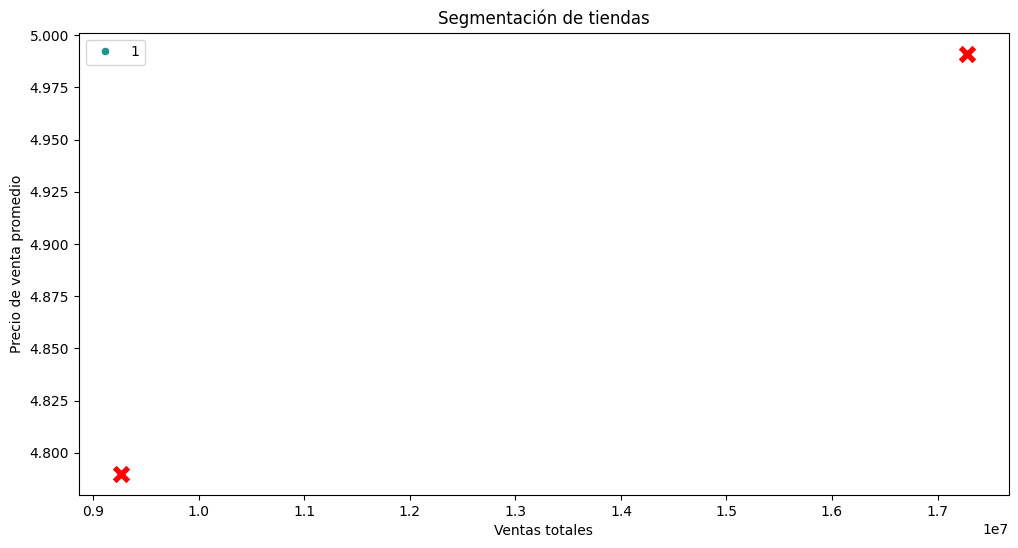

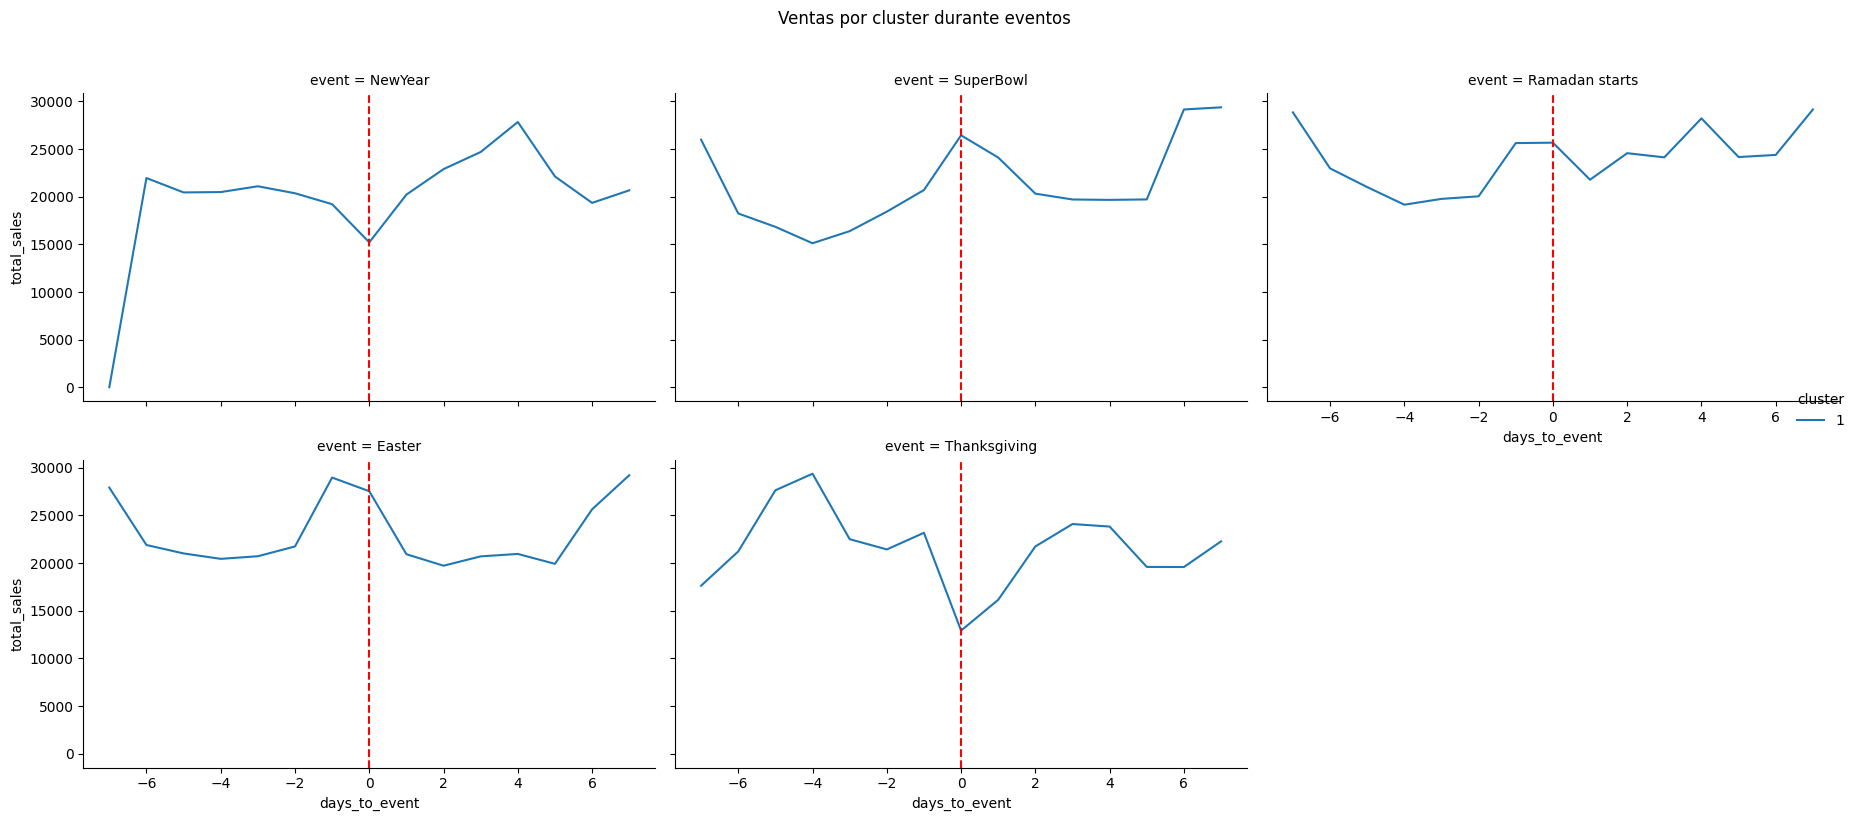

In [37]:
visualize_results(tribeca_seg, tribeca_analysis, centroid_df)

#### **PENDIENTE** => Crear diccionario de cluster con descripciones y añadir a df_items

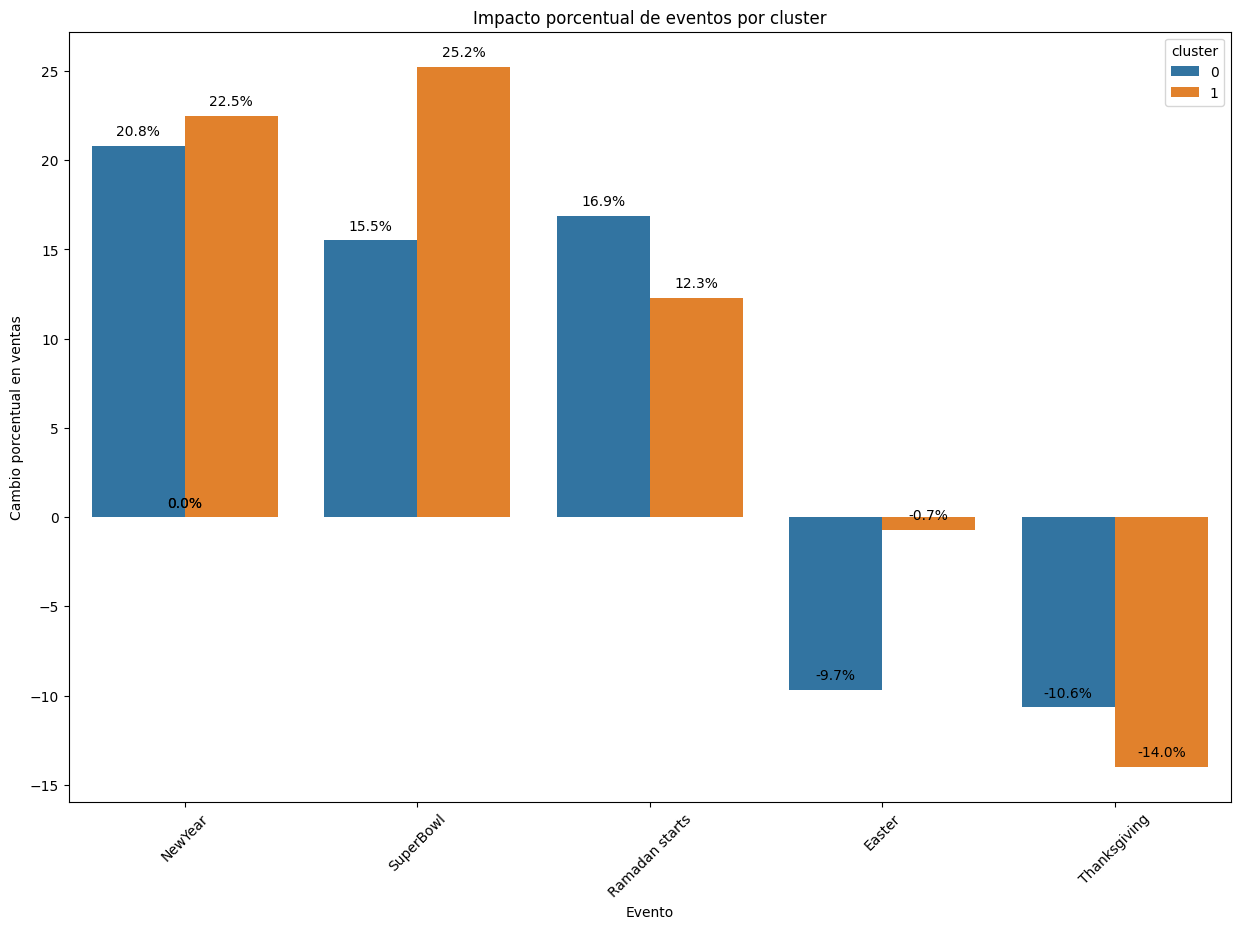

   cluster  percent_change           event
0        0       20.812309         NewYear
1        1       22.494372         NewYear
2        0       15.507355       SuperBowl
3        1       25.238211       SuperBowl
4        0       16.894726  Ramadan starts
5        1       12.308744  Ramadan starts
6        0       -9.658365          Easter
7        1       -0.706812          Easter
8        0      -10.635609    Thanksgiving
9        1      -13.988768    Thanksgiving


In [26]:
# Analisis de impacto de eventos sobre clusters
impact_analysis = analyze_event_impact(event_analysis)
print(impact_analysis)

In [27]:
#  Vemos items por cluster
def plot_clusters_sizes(data_labeled):
    cluster_counts = data_labeled[CLUSTER_COL].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(range(len(cluster_counts))))

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel(CLUSTER_COL)
    ax.set_ylabel('Número de items')
    ax.set_title('Número de items por cluster')
    ax.set_xticks(range(len(cluster_counts)))
    ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_counts))], rotation=0)
    plt.show()

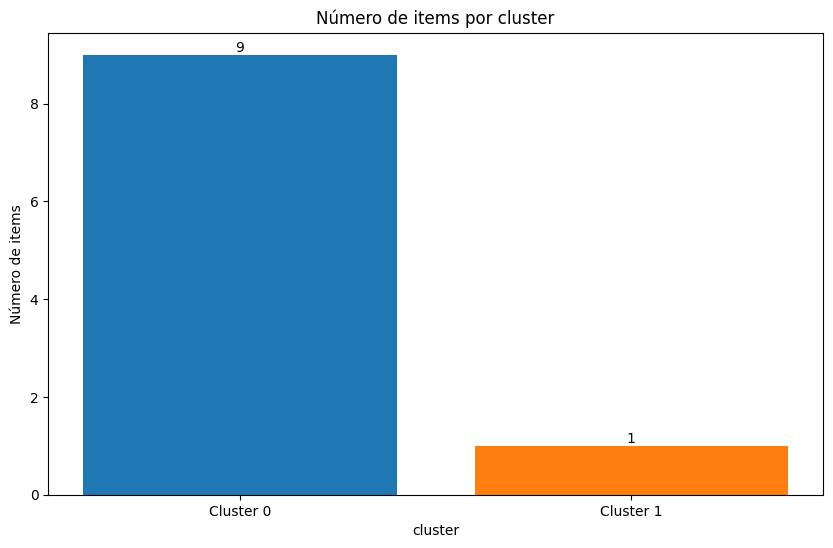

In [28]:
plot_clusters_sizes(store_segments)

# SIN TRIBECA (Top store)

## Laod data

In [29]:
items = df_items.copy()
shops = df_shops.copy()
df_events = df_s.copy()

display(df_events.shape)

(8356979, 12)

In [30]:
df_events.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8801219,SUPERMARKET_3_586,NYC_2,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None
8801220,SUPERMARKET_3_756,NYC_2,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801221,SUPERMARKET_3_565,NYC_3,2013-12-25,1,2013,52,2.976,2.976,12,Wednesday,2,None
8801222,SUPERMARKET_3_756,NYC_3,2013-12-25,2,2013,52,2.976,5.952,12,Wednesday,2,None
8801223,SUPERMARKET_3_555,BOS_1,2013-12-25,1,2013,52,1.896,1.896,12,Wednesday,2,None


In [31]:
shops.head()

,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


In [32]:
# Excluir una tienda específica por su código de tienda
df_events = df_events[df_events['store_code'] != 'NYC_3']

## Tareas

In [33]:
# Preparamos df original
df = prepare_data(df_events) # total_sales = raw_earn

In [34]:
# Creacion caracteristicas sobre fecha (distancia a eventos de cada fecha / venta de item para analisis posterior)
df = create_date_features(df)

In [35]:
# Creacion caracteristicas para segmentacion
df_features, features, store_data = features_creation(df)

In [36]:
# Preprocesamiento
scaled_df, scaler = preprocess_features(df_features, Scaler=SCALER)

In [37]:
# Silhouette
plot_silhouette(scaled_df, ran=9)

In [38]:
# Segmentacion con optimal_k
optimal_k = 2 # Segun grafico de silueta

data = {
    'df_features': df_features,
    'features': features,
    'store_data': store_data,
    'X_scaled': scaled_df,
    'scaler': scaler
}

store_segments, centroid_df = segment_stores_kmeans(data, n_clusters=optimal_k)

El score de silueta promedio es: 0.21516125675983963

Centroides de los clusters:
    total_sales       units  avg_product_sales  sell_price  cluster
0  1.068000e+07  2905711.75          11.498827    4.826794        0
1  8.128841e+06  2213266.40          11.435297    4.760457        1


In [39]:
# Clusters asignados a items
store_segments.head()

,store_code,total_sales,units,avg_product_sales,sell_price,cluster
0,BOS_1,8.372667e+06,2292731,11.848440,4.780196,1
1,BOS_2,1.016845e+07,2745173,11.640712,4.859419,0
2,BOS_3,1.009387e+07,2620406,11.864472,4.879028,0
3,NYC_1,1.217453e+07,3238077,11.218431,4.972541,0
4,NYC_2,8.871384e+06,2262857,11.409632,4.994075,1


In [40]:
event_analysis = analyze_events_with_segments(df, store_segments)

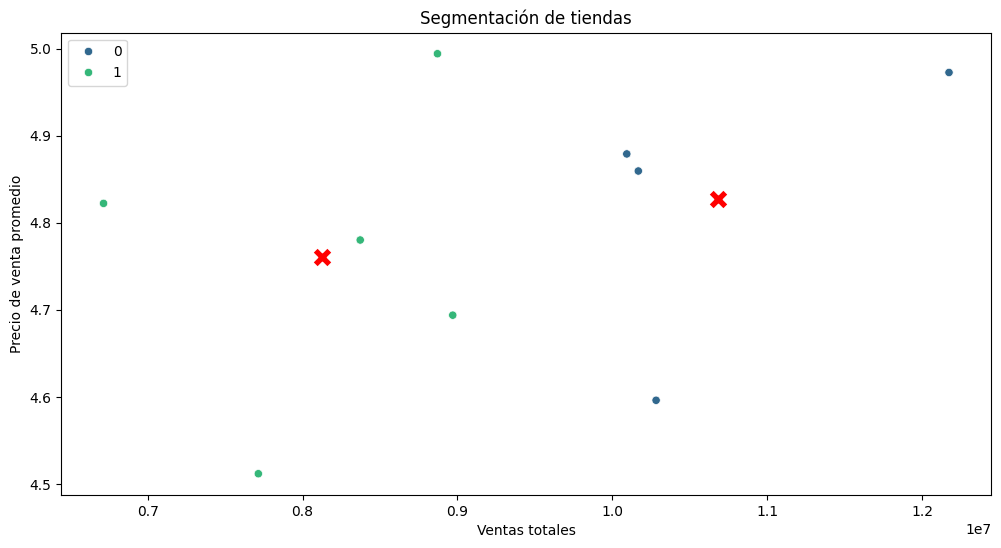

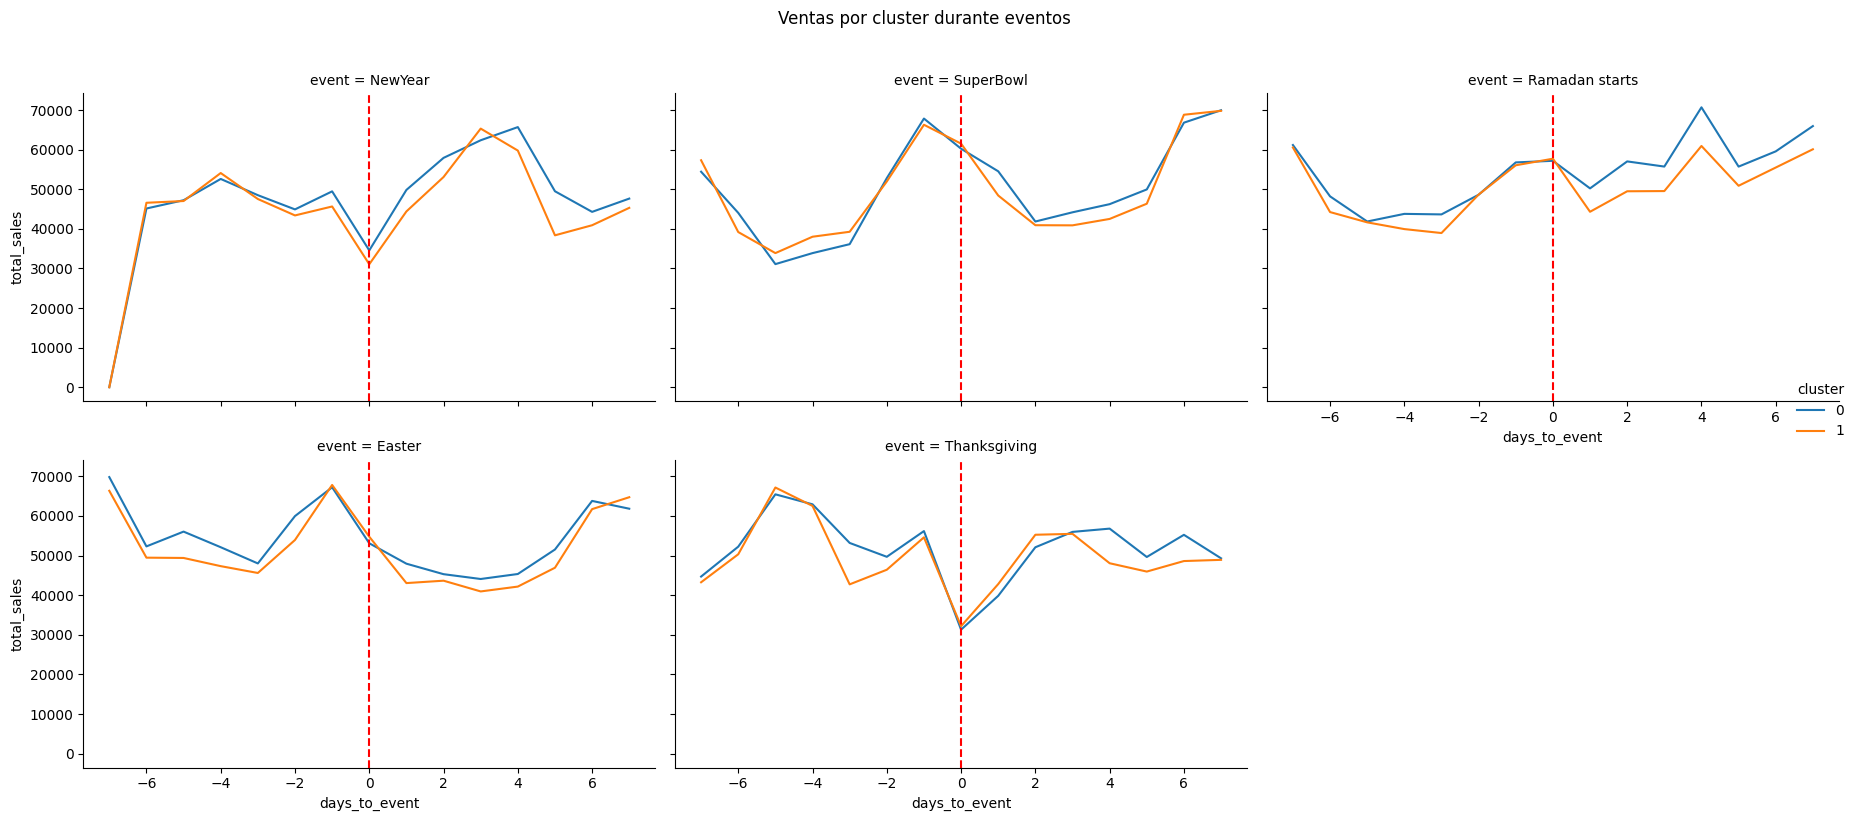

In [41]:
visualize_results(store_segments, event_analysis, centroid_df)

#### **PENDIENTE** => Crear diccionario de cluster con descripciones y añadir a df_items

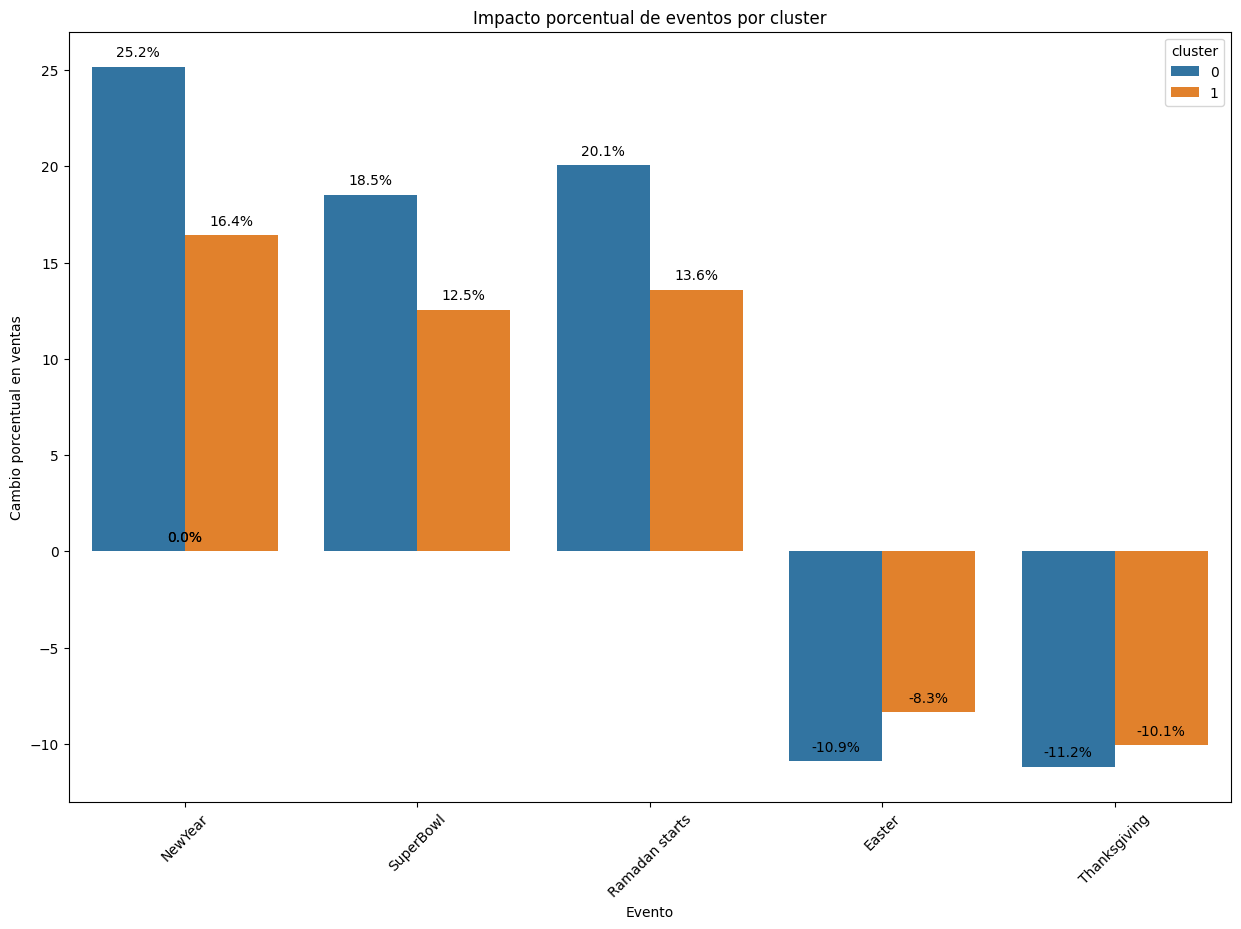

   cluster  percent_change           event
0        0       25.165129         NewYear
1        1       16.404695         NewYear
2        0       18.518872       SuperBowl
3        1       12.548372       SuperBowl
4        0       20.058268  Ramadan starts
5        1       13.596600  Ramadan starts
6        0      -10.892433          Easter
7        1       -8.341182          Easter
8        0      -11.181230    Thanksgiving
9        1      -10.064205    Thanksgiving


In [42]:
# Analisis de impacto de eventos sobre clusters
impact_analysis = analyze_event_impact(event_analysis)
print(impact_analysis)

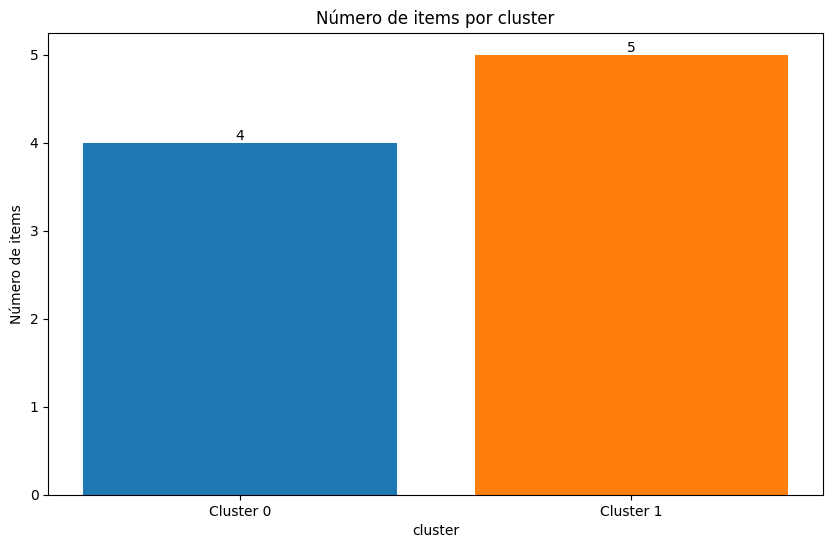

In [44]:
plot_clusters_sizes(store_segments)

# Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_with_events_influence.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# products_segments.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)